# spaTrack adapt to scRNA-seq data

Besides spatial transcriptomics data, spaTrack can also apply trajectory inference to scRNA-seq data by considering only UMAP coordinates.This notebook demonstrates how spaTrack performs trajectory inference on scRNA-seq data using human hematopoiesis cells (HSPC) as an example. The example data can be donwloaded from [Baidu Netdisk](https://pan.baidu.com/s/1XajO8wGu20v6ujgERvCWfg?pwd=g3cc) and [Google Drive](https://drive.google.com/file/d/1vY5qVJJsUFq1sy1mvhslyqw56Ujdbkko/view?usp=sharing).

In [1]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

## 1. Import the HSC data

Convert tsv files to scanpy adata. When run spaTrack on scRNA-seq data,we recommended that cell type information can placed in 'adata.obs['cluster']', and UMAP coordinates can be placed in 'X_UMAP' or 'X_umap'.

In [2]:
adata = sc.read("../data/HSPC.Sc-RNA.data/HSPC.sc.expression.tsv")
anno = pd.read_table("../data/HSPC.Sc-RNA.data/UMAP_coor.annot.tsv",)

adata.obs.index = anno["Cell_id"].values
adata.obs["cluster"] = anno["Annot"].values
adata.obsm["X_UMAP"] = anno[['UMAP_1','UMAP_2']].values

adata.var_names_make_unique()

Perform basic preprocessing and then visualize the data.

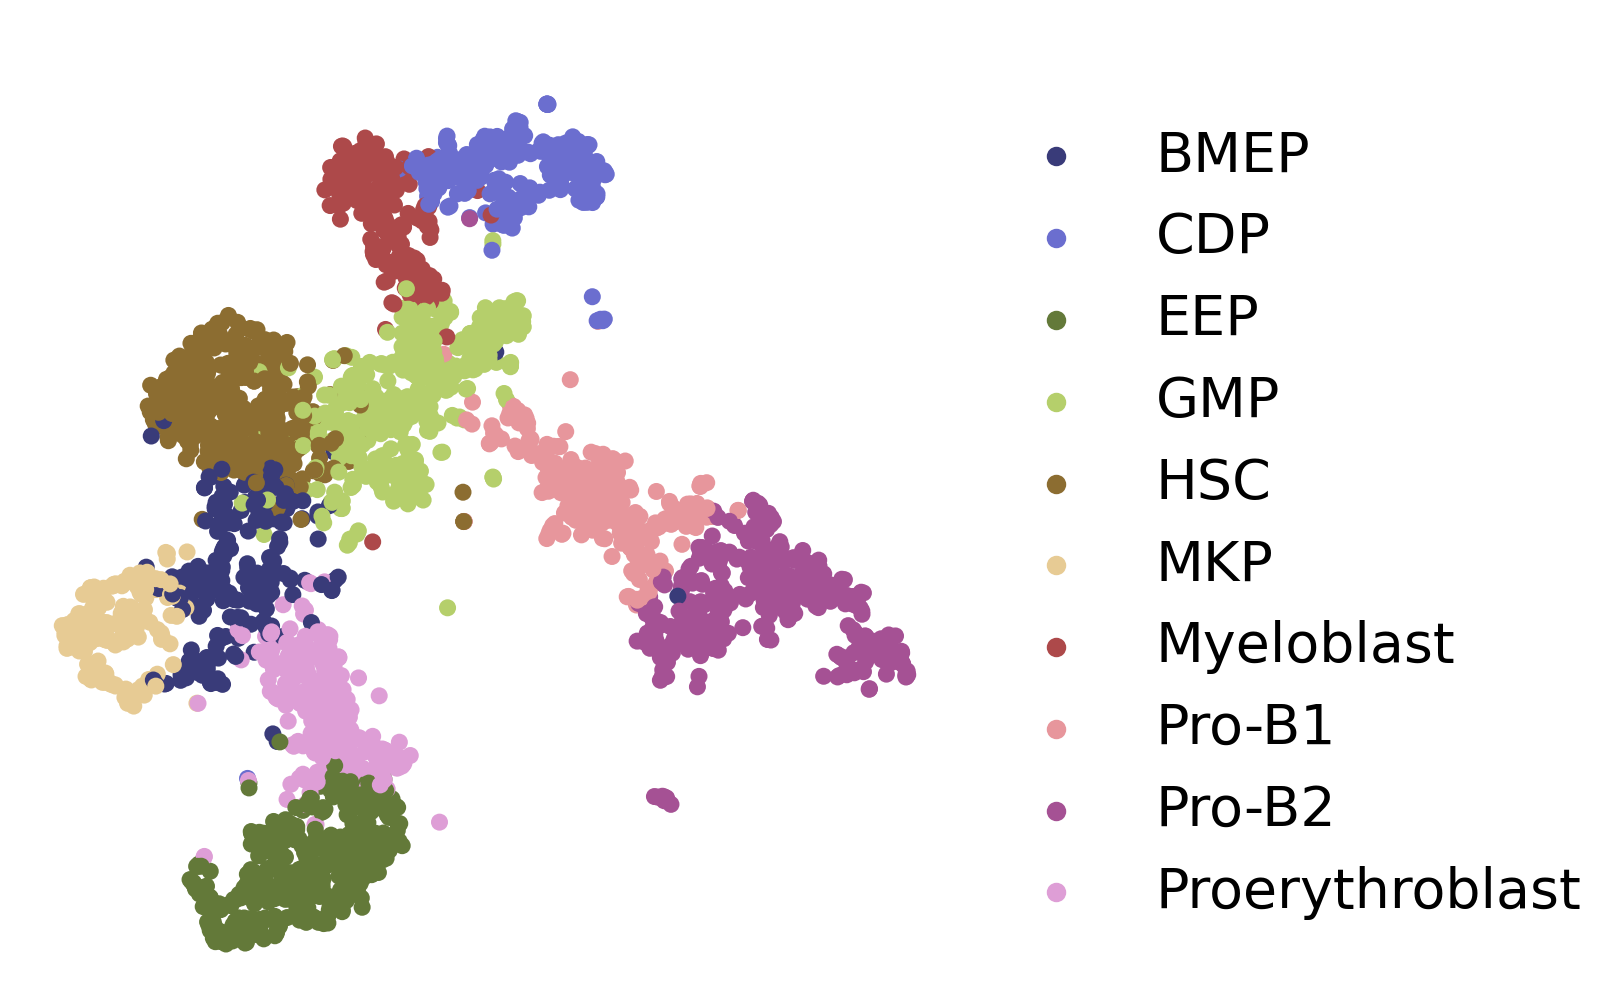

In [3]:
sc.pp.filter_genes(adata,min_cells=30)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
fig, axs = plt.subplots(figsize=(6, 6))
ax = sc.pl.embedding(adata,  basis='X_UMAP',show=False,color='cluster',ax=axs,frameon=False,title=' ',palette='tab20b',size=150, legend_fontsize=20)

## 2. Choose start cells

Based on prior biological knowledge, HSC(hematopoietic stem cells) have the ability to self-renew and differentiate into various blood cell types, making them essential for the production and replenishment of blood cells in the body. We set HSC as the starting cluster in this data.

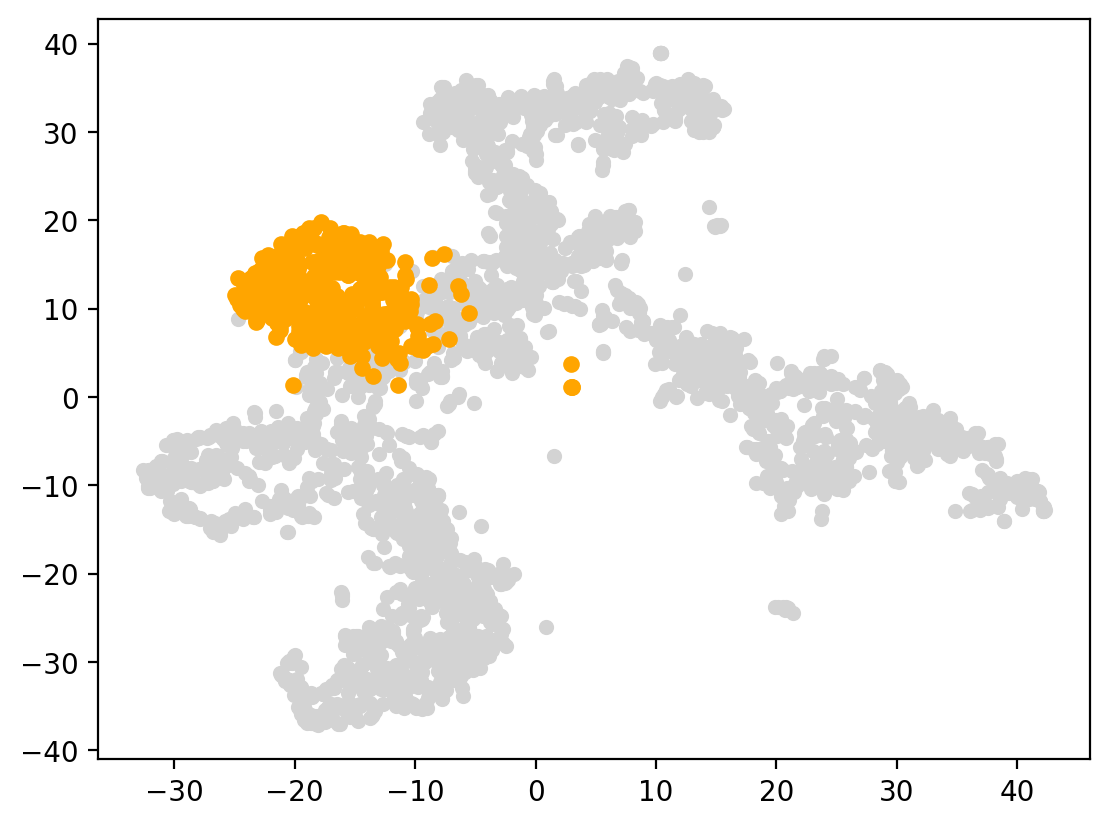

In [4]:
start_cells=spt.set_start_cells(adata,select_way='cell_type',cell_type='HSC')
plt.scatter(adata.obsm['X_UMAP'][:,0],adata.obsm['X_UMAP'][:,1],c='#D3D3D3',s=20)
plt.scatter(adata.obsm['X_UMAP'][start_cells][:,0],adata.obsm['X_UMAP'][start_cells][:,1],c='orange',s=25)

## 3. Calculate cell transition probability

Calculate cell transition probability matrix between cells.

In [5]:
adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='single-cell')

X_pca is not in adata.obsm, automatically do PCA first.


## 4. Caculate cell pseudotime

Infer the cell pseudotime based on the OT matrix and start cells. 

In [6]:
adata.obs['ptime']=spt.get_ptime(adata,start_cells)

## 5. Calculate vector field velocity.

In [7]:
adata.uns['E_grid'],adata.uns['V_grid']=spt.get_velocity(adata,basis='UMAP',n_neigh_pos=100,n_neigh_gene=0)

The velocity of cells store in 'velocity_UMAP'.


Display the UMAP of cells, starting cells, the cell pseudotime and the inferred cell trajectory respectively.

## 6. Plot results

Display the UMAP plots of cells, starting cells, cell pseudotime, and the inferred cell trajectory.

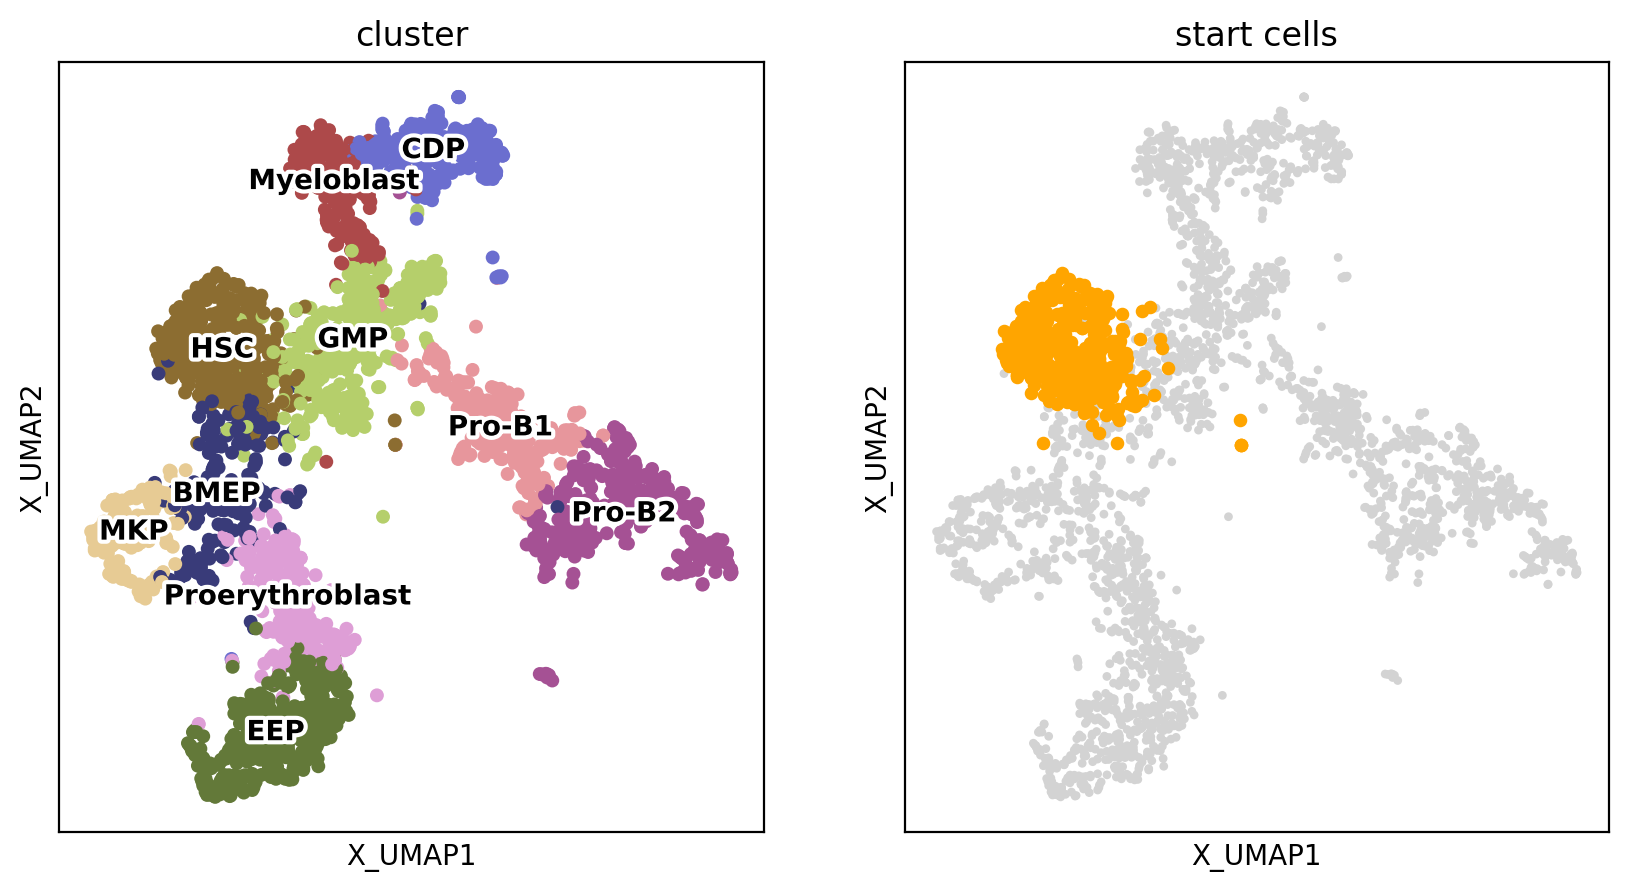

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
sc.pl.embedding(adata, basis='X_UMAP', color='cluster', size=20, legend_loc='on data', ax=axs[0], legend_fontoutline=3, show=False, s=100)

start_points = sc.pl.embedding(adata, basis='X_UMAP',ax=axs[1], show=False, title='start cells')
points = adata.obsm['X_UMAP'][adata.obs['cluster'] == 'HSC']
start_points.scatter(points[:, 0], points[:, 1], s=15, color='orange')


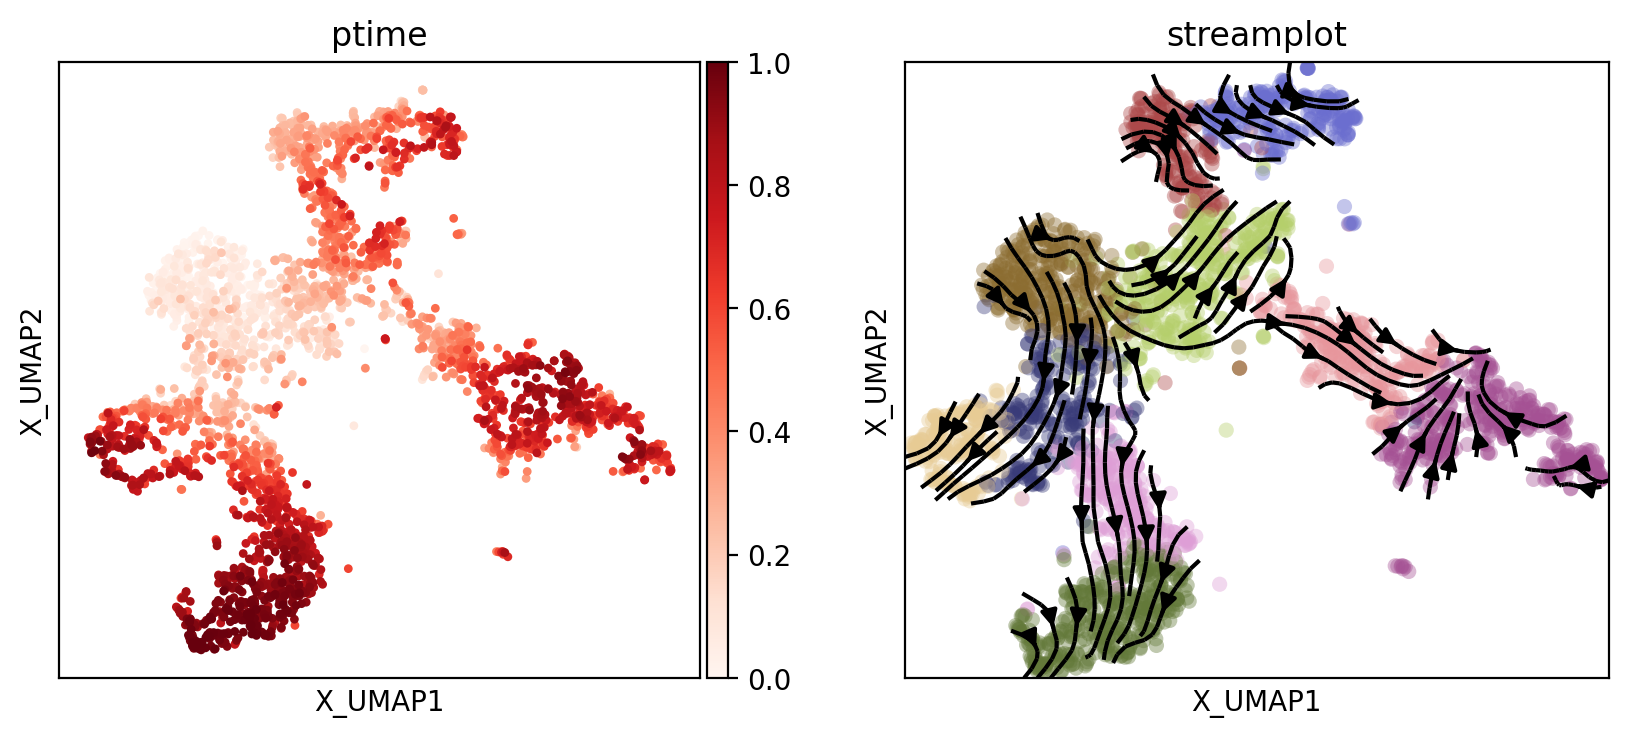

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
sc.pl.embedding(adata, basis='X_UMAP', color='ptime', show=False, ax=axs[0], color_map='Reds', title='ptime')

vf_velocity = sc.pl.embedding(adata, basis='X_UMAP', show=False, ax=axs[1],color='cluster',title='streamplot',  legend_loc=None, alpha=0.4, size=120)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=1.5,density=1.8,arrowsize=1.2,)

## 7. Downstream analysis

### 7.1 Least Action Path (LAP)

In [10]:
VecFld=spt.VectorField(adata,basis='UMAP')

Select the start point and the end point of the least action path.

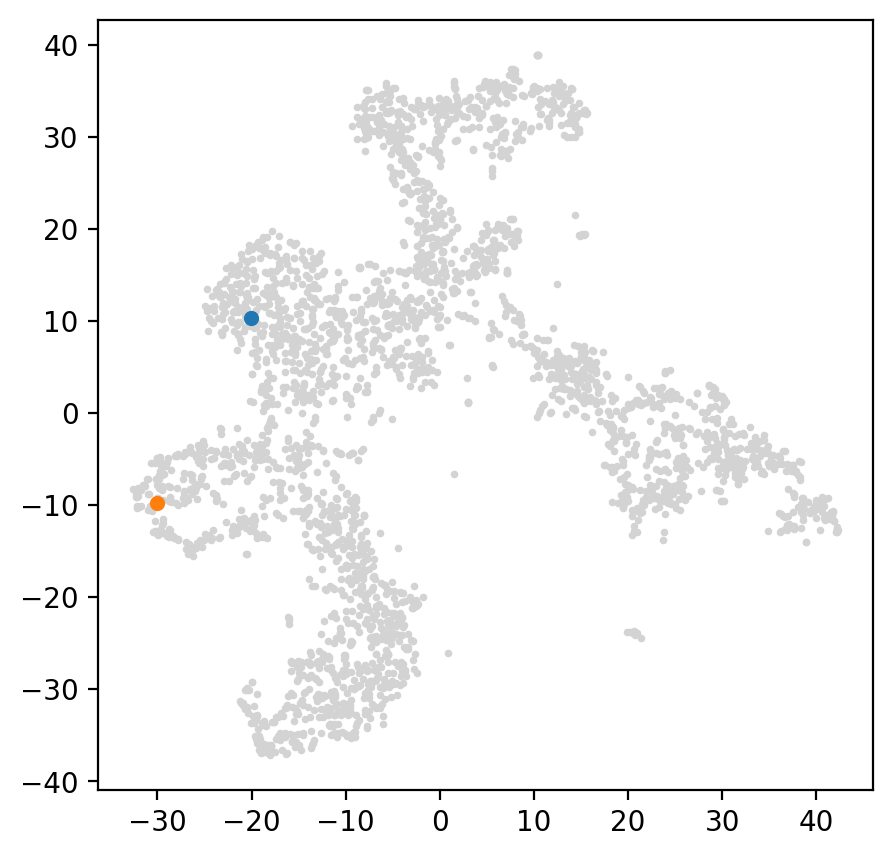

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

LAP_start_point=[-20,10]
LAP_end_point=[-30,-10]
LAP_start_cell=spt.nearest_neighbors(LAP_start_point,adata.obsm['X_UMAP'])[0][0]
LAP_end_cell=spt.nearest_neighbors(LAP_end_point,adata.obsm['X_UMAP'])[0][0]

plt.scatter(*adata.obsm["X_UMAP"].T,c='#D3D3D3',s=3)
plt.scatter(*adata[LAP_start_cell].obsm['X_UMAP'].T,s=20)
plt.scatter(*adata[LAP_end_cell].obsm['X_UMAP'].T,s=20)


Calculate the least action path between the given starting cells and end cells. 

In [12]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='UMAP',
    adj_key='X_UMAP_distances',
    EM_steps=10,
    n_points=20
)

Plot the least action Path.

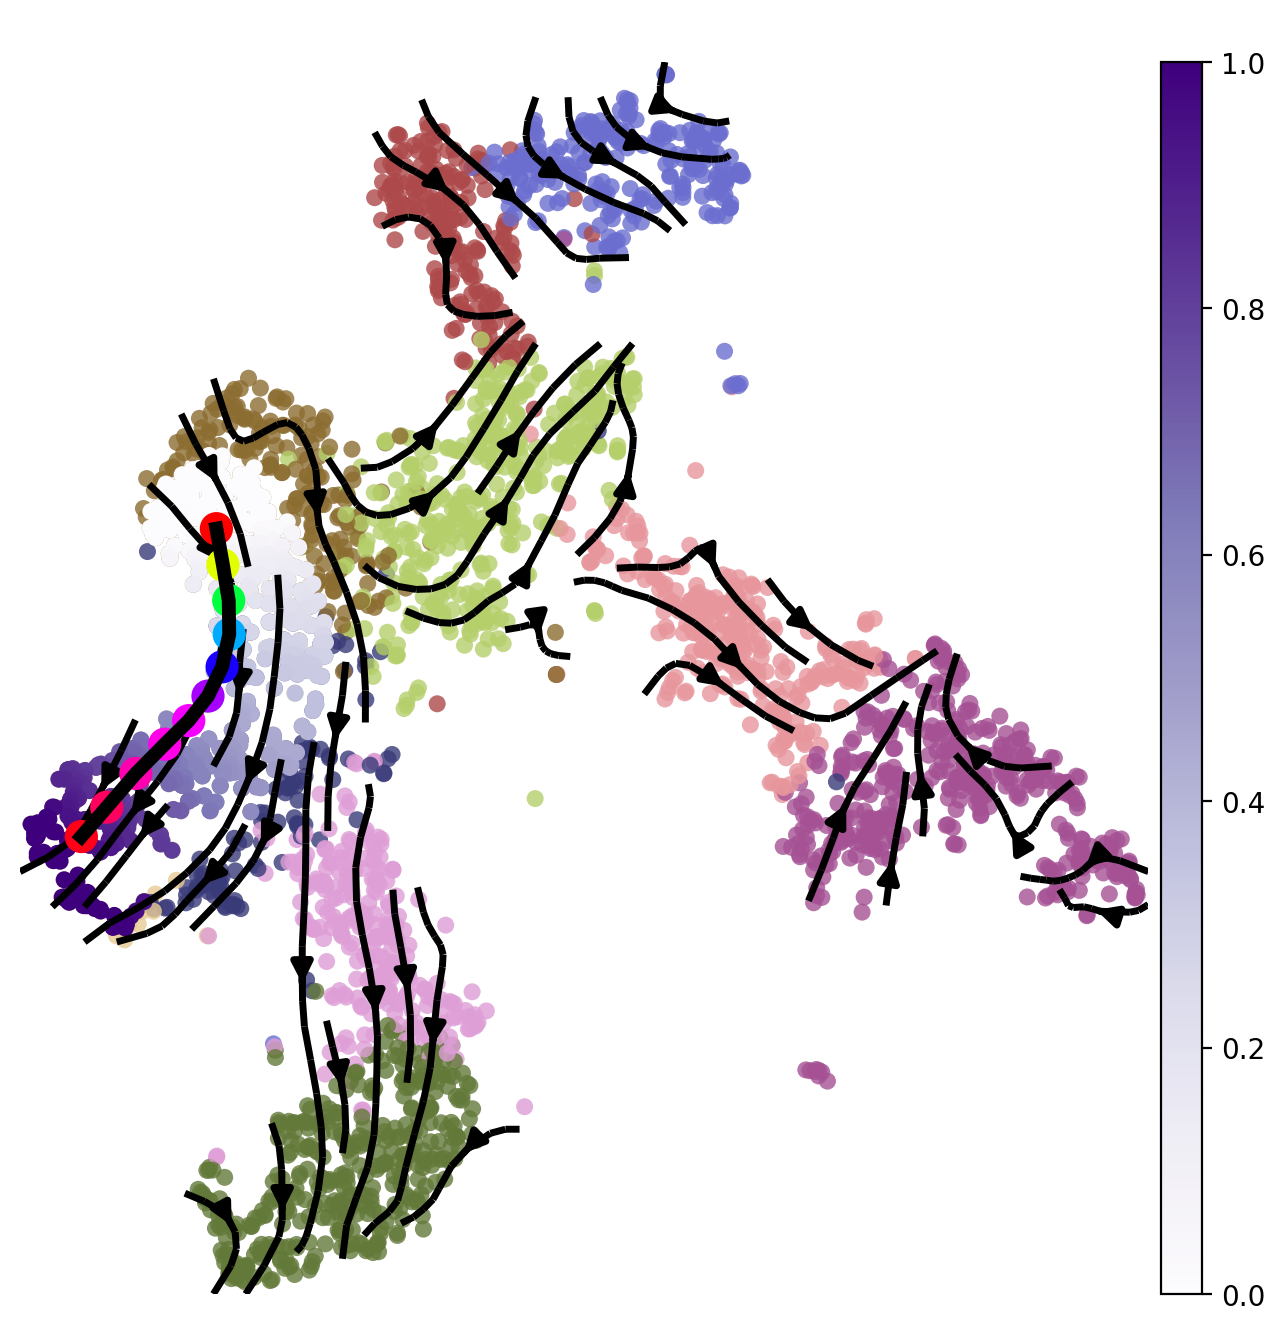

In [13]:
LAP_ptime,LAP_nbrs=spt.lap.map_cell_to_LAP(adata,basis='UMAP')
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

fig, ax = plt.subplots(figsize=(8,8))
plt.axis('off')
ax = sc.pl.embedding(adata,  basis='X_UMAP',color='cluster',show=False,ax=ax,frameon=False,legend_loc=None,alpha=0.8,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.2,color='black',linewidth=2.5,arrowsize=1.5,minlength=0.1,maxlength=0.8)
ax = spt.plot_least_action_path(adata,basis='UMAP',ax=ax,point_size=120,linewidth=5)
sc.pl.embedding(sub_adata, basis='X_UMAP',ax=ax, color="ptime", cmap="Purples",frameon=True,size=150,title=' ')

### 7.2 Pseudotime-dependent genes on LAP

Select the targeted cell type for least action path (LAP) analysis and filter out genes with highly variable and expression below the minimum proportion.

In [14]:
sub_adata_path=sub_adata[sub_adata.obs['cluster'].isin(['HSC','BMEP','MKP'])]
sub_adata_path=spt.filter_gene(sub_adata_path,min_exp_prop=0.1,hvg_gene=5000)

clusters ordered by ptime:  ['HSC', 'BMEP', 'MKP']
Cell number	504
Gene number	2267


Next, we use a Generalized Additive Model to fit the gene expression and corresponding cell pseudotime. Pseudotime-dependent genes are then filtered based on the degree of model fit and the false discovery rate (FDR). To visualize pseudotime-dependent genes across the trajectory, we partition the cells ordered by pseudotime into windows and rank genes based on their maximum expression within each window.

In [15]:
df_res=spt.ptime_gene_GAM(sub_adata_path,core_number=5)
df_sig_res = df_res.loc[(df_res['model_fit']>0.4) & (df_res['fdr']<0.05)]

Genes number fitted by GAM model:   2267


In [16]:
df_sig_res

,gene,pvalue,model_fit,pattern,fdr
ACTN1,ACTN1,1.110223e-16,0.483401,increase,1.108756e-15
AIF1,AIF1,1.110223e-16,0.458285,decrease,1.108756e-15
AVP,AVP,1.110223e-16,0.791367,decrease,1.108756e-15
B2M,B2M,1.110223e-16,0.725325,decrease,1.108756e-15
BIRC5,BIRC5,1.110223e-16,0.497887,increase,1.108756e-15
...,...,...,...,...,...
TPT1,TPT1,1.110223e-16,0.846893,decrease,1.108756e-15
TYMS,TYMS,1.110223e-16,0.578346,increase,1.108756e-15
UBE2C,UBE2C,1.110223e-16,0.605581,increase,1.108756e-15
VIM,VIM,1.110223e-16,0.424371,decrease,1.108756e-15


Order genes and plot the heatmap.

Finally selected 102 genes.


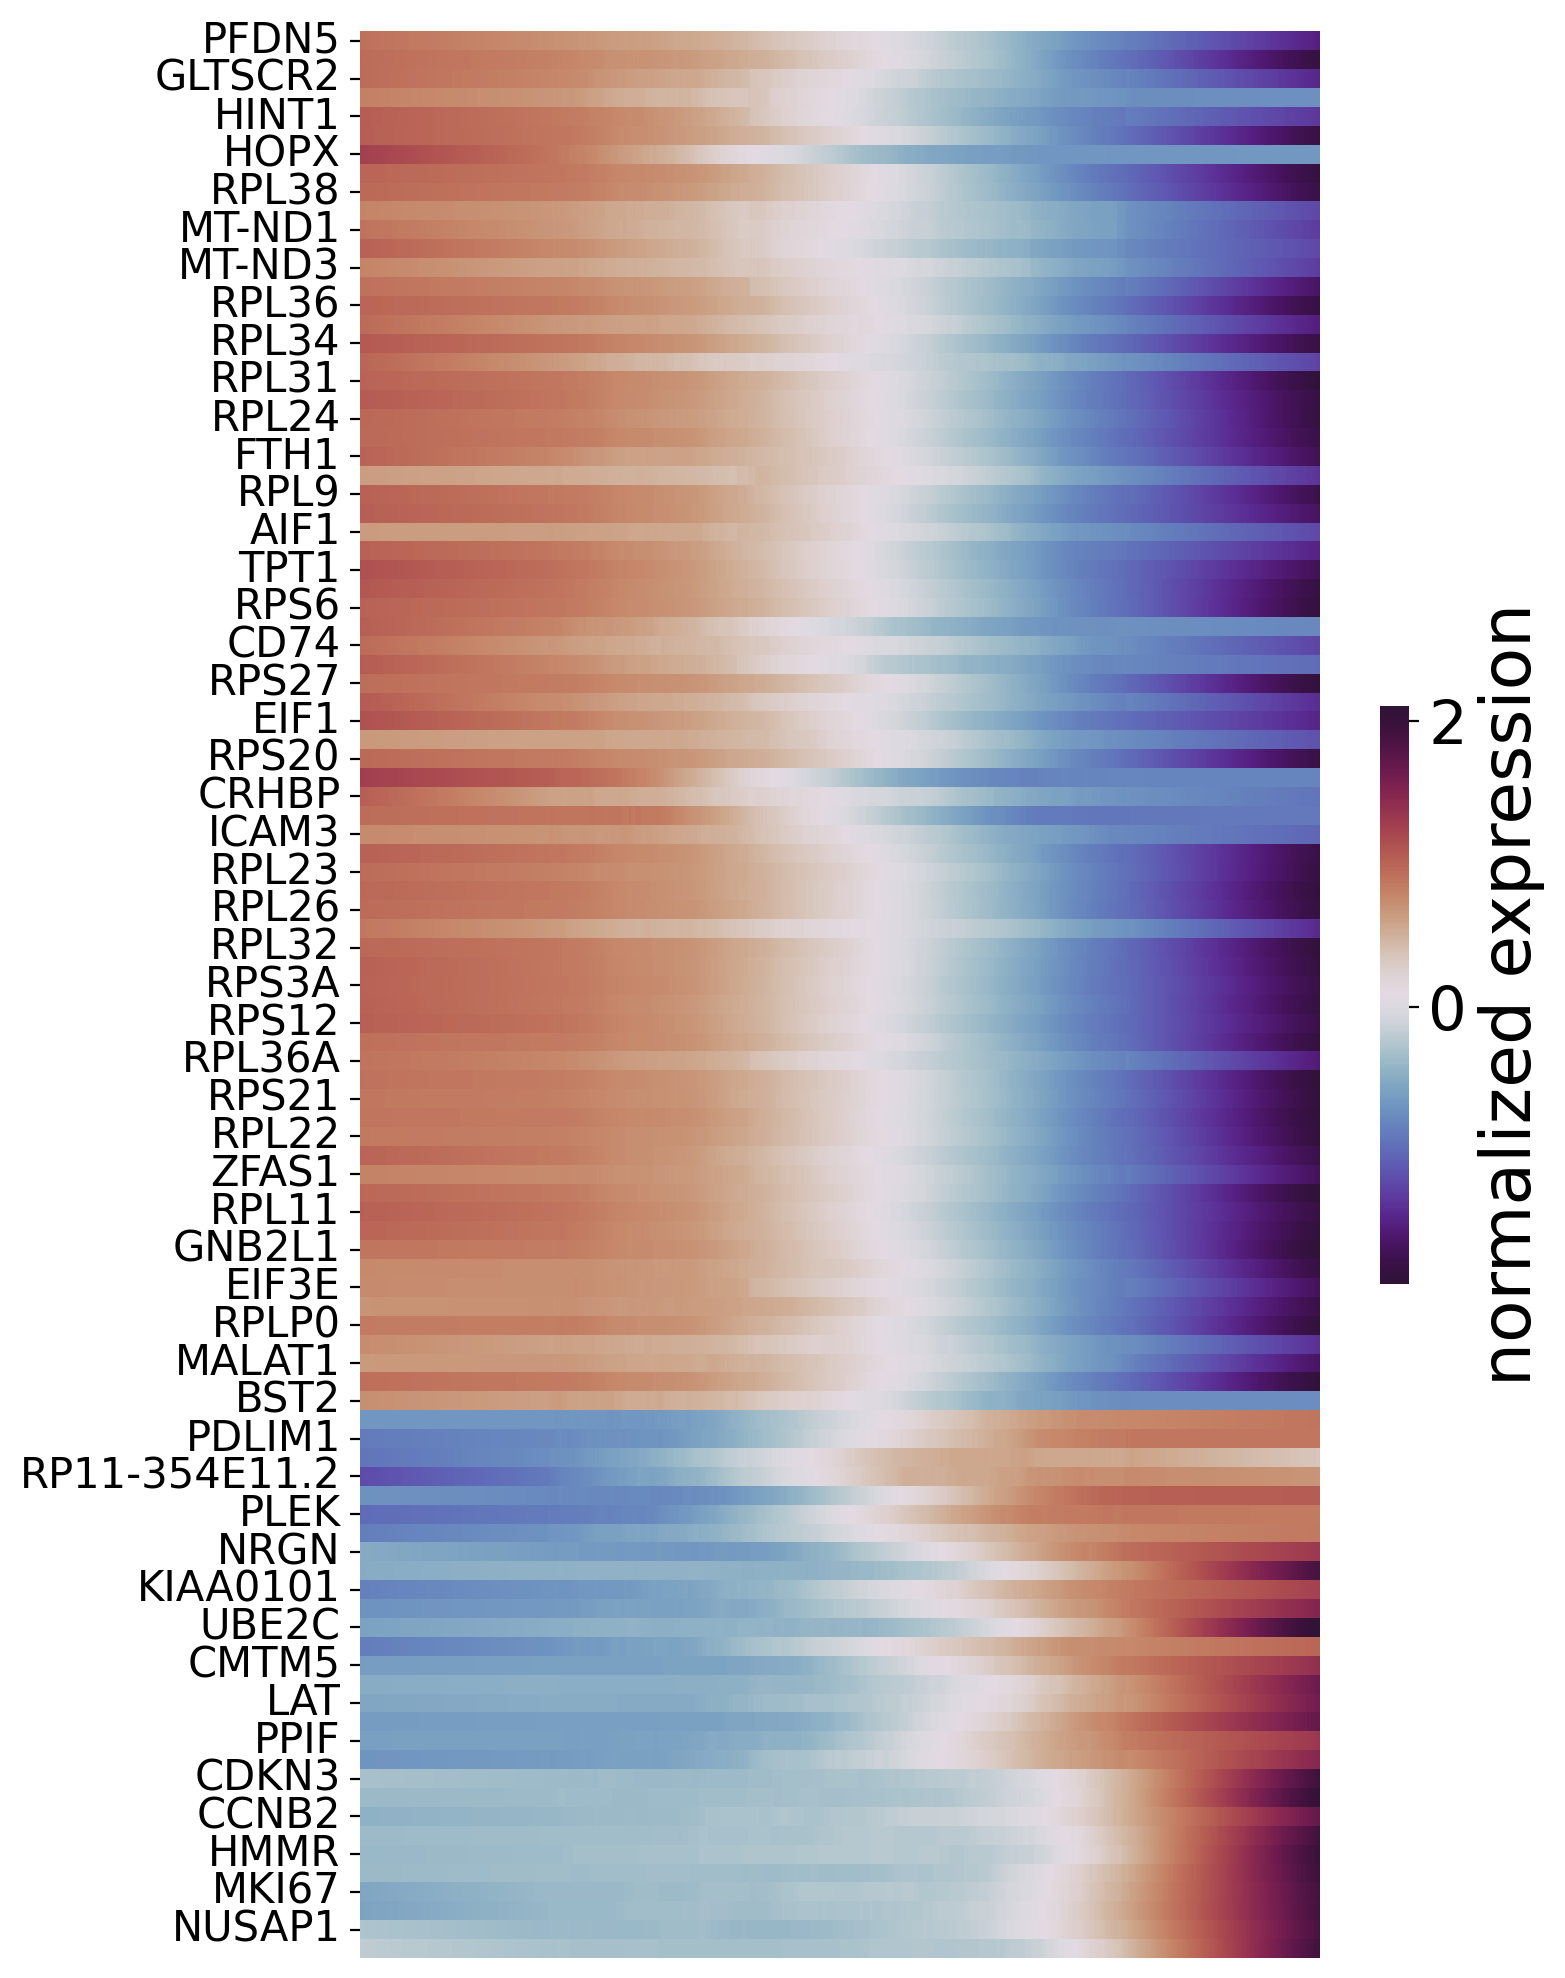

In [17]:
sort_exp_sig = spt.order_trajectory_genes(sub_adata,df_sig_res,cell_number=30)
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=200,gene_label_size=15,cmap_name='twilight_shifted')

Show the relationship between genes and ptime.

<Axes: title={'center': 'VIM'}, xlabel='ptime', ylabel='expression'>

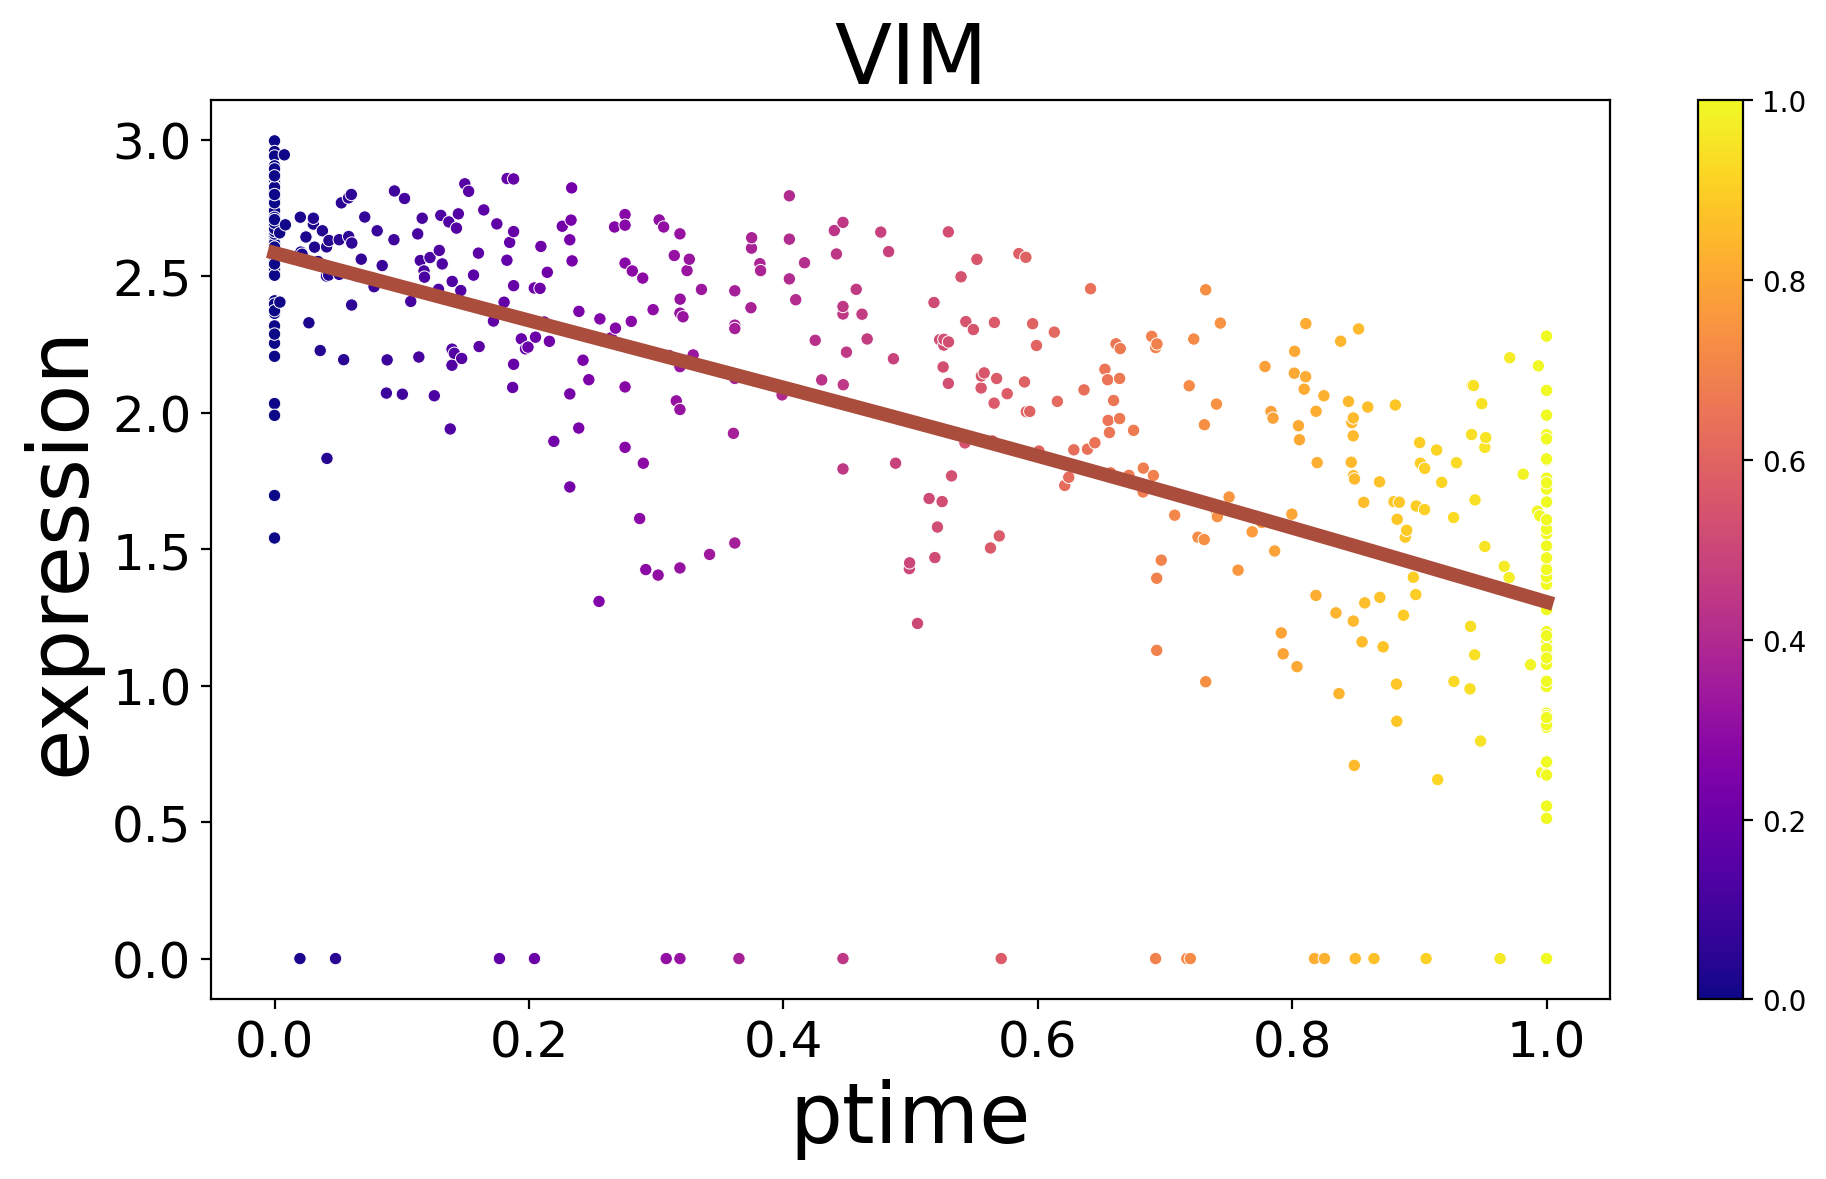

In [18]:
spt.plot_trajectory_gene(sub_adata_path,gene_name='VIM',show_cell_type=False)